In [2]:
from pathlib import Path

import geopandas as gpd
import pandas as pd

In [3]:
BUURT_PATH = Path("./data/buurt_2015")
DEST_PATH = Path("./data/transformed/population.shp")
DEST_PATH.parent.mkdir(exist_ok=True)

In [ ]:
%%bash
# set -e

export FN="./data/buurt_2015.zip"
export DEST_DIR="./data/buurt_2015"

mkdir -p ${DEST_DIR}
wget --quiet -O ${FN} https://www.cbs.nl/-/media/_pdf/2017/36/buurt_2015.zip
unzip ${FN} -d ${DEST_DIR}

In [5]:
geo = gpd.read_file(BUURT_PATH / "wijk_2015.shp")
geo.head()

,WK_CODE,WK_NAAM,GM_CODE,GM_NAAM,IND_WBI,WATER,OAD,STED,AANT_INW,AANT_MAN,...,AV50ATTRAC,AF_PODIUM,AV5_PODIUM,AV10PODIUM,AV20PODIUM,AF_POP,OPP_TOT,OPP_LAND,OPP_WATER,geometry
0,WK000300,Wijk 00,GM0003,Appingedam,1,NEE,1020,3,12010,5805,...,11.2,5.6,0.2,1.0,1.0,24.6,2458,2377,81,"POLYGON ((254777.541 596451.767, 254778.938 59..."
1,WK000500,Wijk 00,GM0005,Bedum,1,NEE,673,4,10440,5220,...,18.3,9.6,0.0,1.6,6.1,9.6,4496,4454,41,"POLYGON ((235109.734 586121.082, 235105.783 58..."
2,WK000700,Wijk 00 Bellingwolde,GM0007,Bellingwedde,1,NEE,118,5,4205,2130,...,12.2,12.1,0.0,0.0,1.2,47.6,4364,4295,69,"POLYGON ((270040.406 565905.375, 269997.000 56..."
3,WK000701,Wijk 01 Oost,GM0007,Bellingwedde,1,NEE,46,5,960,505,...,14.1,14.2,0.0,0.0,1.7,45.7,2450,2411,39,"POLYGON ((273858.688 567837.625, 273917.500 56..."
4,WK000702,Wijk 02 Blijham,GM0007,Bellingwedde,1,NEE,209,5,3985,1970,...,17.0,7.4,0.0,0.8,3.0,42.6,4194,4130,64,"POLYGON ((269321.500 568419.688, 269505.594 56..."


### Select columns
- Name of neighbourhood
- Name of municupality
- Number of inhabitans
- Geometry

The following might also be interesting later:

    P_00_14_JR: Personen 0 tot 15 jaar [%] 
    P_15_24_JR: Personen 15 tot 25 jaar [%] 
    P_25_44_JR: Personen 25 tot 45 jaar [%] 
    P_45_64_JR: Personen 45 tot 65 jaar [%]
    P_65_EO_JR: Personen 65 jaar en ouder [%]

In [6]:
geo_sel = (
    geo
    [["WK_NAAM", "GM_NAAM", "AANT_INW", "geometry"]]
    .rename(columns={
        "WK_NAAM": "hood",
        "GM_NAAM": "muni",
        "AANT_INW": "pop"
    })
    .sort_values(by=["muni", "hood"])
    # Convert from Dutch system where Amersfoort is the center of the world,
    # to WSG 84 / EPSG 4326, the default for GPS
    .to_crs("epsg:4326")  
    .assign(centroid=lambda df: df["geometry"].map(lambda x: x.centroid))
    .query("pop > 0")  # There are some -99999999, some 0.
)
geo_sel.head()

,hood,muni,pop,geometry,centroid
1219,Wijk 02 Belgisch Park,'s-Gravenhage,7955,"POLYGON ((4.28747 52.11845, 4.28772 52.11856, ...",POINT (4.29201 52.11208)
1220,Wijk 03 Westbroekpark en Duttendel,'s-Gravenhage,1855,"POLYGON ((4.30000 52.09899, 4.29965 52.09913, ...",POINT (4.30321 52.10403)
1221,Wijk 04 Benoordenhout,'s-Gravenhage,13320,"POLYGON ((4.32739 52.09566, 4.32748 52.09557, ...",POINT (4.32134 52.09741)
1222,Wijk 05 Archipelbuurt,'s-Gravenhage,5720,"POLYGON ((4.29996 52.09864, 4.30039 52.09855, ...",POINT (4.30271 52.09184)
1223,Wijk 06 Van Stolkpark en Scheveningse Bosjes,'s-Gravenhage,775,"POLYGON ((4.28612 52.10404, 4.28637 52.10415, ...",POINT (4.29148 52.09752)


115    10
15      9
220     9
275     8
30      8
Name: pop, dtype: int64

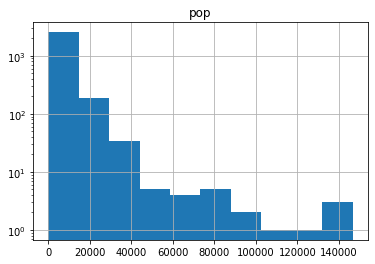

In [7]:
geo_sel.hist(column="pop", log=True)
geo_sel["pop"].value_counts().head()

In [8]:
# It doesn't want to save with centroid so we'll recreate it after loading:
geo_sel.drop("centroid", axis=1).to_file(str(DEST_PATH))